# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project aims to apply Natural Language Processing (NLP) techniques to analyze the content of comments that are publicly available on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149) for this docket. For technical reasons (see the [Data_Prep notebook](./Data_Prep.ipynb)), the dataset only includes ~8K comments, which are the ones typed directly onto the site. The dataset excludes another ~3K comments submitted in an attachment form (most of which were PDFs).

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [163]:
import re
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
from wordcloud import WordCloud

In [2]:
full_df = pd.read_pickle('./Data/full_df.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...


## Topic Analysis

In [67]:
# Process comment column for topic analysis

# Remove punctuation
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: x.lower())

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Comment_processed
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...","my husband and i have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,please do not change the definitions within th...


In [68]:
comments = full_df['Comment_processed']

comments.head()

0    i write to express my opposition to the enviro...
1    i write to express my opposition to the enviro...
2    please abandon this proposed rollback of the 2...
3    my husband and i have two wonderful daughters,...
4    please do not change the definitions within th...
Name: Comment_processed, dtype: object

In [70]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic-by-vocabulary orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [71]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    import matplotlib.pyplot as plt
    
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()

In [128]:
# Transform comments to a matrix of comments by word counts
#   then to normalized TF-IDF representation

# Create frequency counts and generate corpus vocabulary
count_vec = CountVectorizer(stop_words='english')
count_data = count_vec.fit_transform(comments)
print(count_data.shape)

# Create array of vocabulary terms
vocab = np.array(count_vec.get_feature_names())

# Calculate TF-IDF stats
tfidf = TfidfTransformer()
tfidf_data = tfidf.fit_transform(count_data)
print(tfidf_data.shape)

(8187, 22434)
(8187, 22434)


In [165]:
# Test just TFIDF vectorizer
tf_vec = TfidfVectorizer(stop_words='english')
tfv_data = tf_vec.fit_transform(comments)
vocab_2 = np.array(tf_vec.get_feature_names())
print(tfv_data.shape)

(8187, 22434)


In [129]:
s = 1100
print(vocab[s:s+100])

['abomination' 'abound' 'abounds' 'aboutepa' 'aboveground' 'aboveis' 'abq'
 'abraham' 'abrahams' 'abrahamson' 'abrams' 'abreast' 'abridge' 'abridged'
 'abroad' 'abrogated' 'abrogation' 'abrsorbing' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absolve' 'absorb' 'absorbed'
 'absorbing' 'absorbs' 'absorption' 'abstention' 'abstract' 'absurd'
 'absurdities' 'absurdity' 'absurdly' 'abudent' 'abudt' 'abundance'
 'abundant' 'abundent' 'abuse' 'abused' 'abuses' 'abusing' 'abusive'
 'abut' 'abuting' 'abuts' 'abutted' 'abutting' 'abysmal' 'academia'
 'academic' 'academically' 'academy' 'accelerate' 'accelerated'
 'accelerates' 'accelerating' 'accept' 'acceptability' 'acceptable'
 'acceptance' 'accepted' 'acceptible' 'accepting' 'accepts' 'access'
 'accesse' 'accessed' 'accessibility' 'accessible' 'accessing'
 'accheivment' 'accident' 'accidental' 'accidentally' 'accidents'
 'accolades' 'accomadate' 'accommodate' 'accommodating' 'accomodate'
 'accompanied' 'accompanies' 'accompany' 'ac

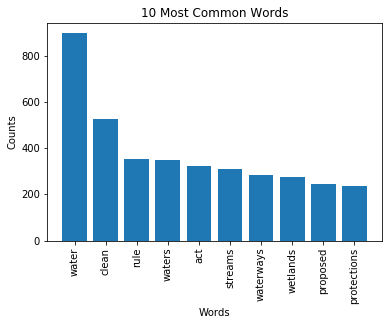

In [167]:
plot_most_common_words(tfidf_data, count_vec)

### Generate a Word Cloud

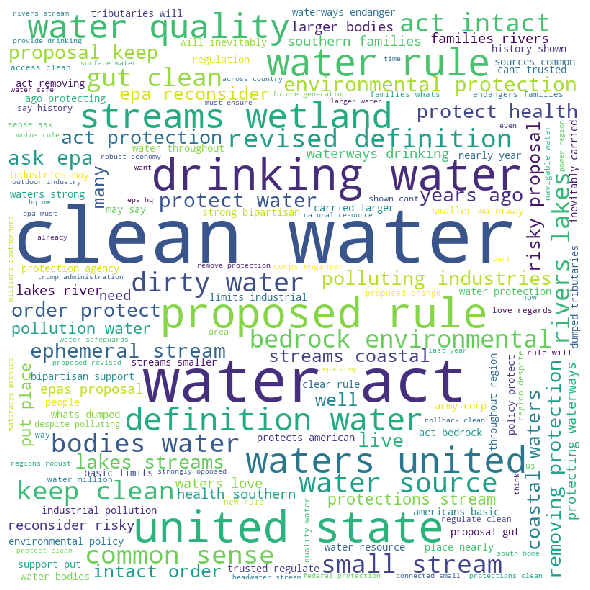

In [124]:
# Combine comments into one "text"
text = ' '.join(comments)

wordcloud = WordCloud(width = 800,
                      height = 800, 
                      background_color ='white',
                      min_font_size = 10).generate(text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0)  
plt.show() 

### Singular Value Decomposition Analysis

In [168]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(tfv_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(8187, 8187) (8187,) (8187, 22434)


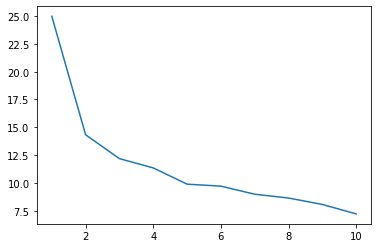

In [169]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);

In [170]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['torrance rosamond winthrop devan faillacetarrytown jaegerssaint gratefully ironic',
 'families proposal risky bipartisan love limits coastal waterways',
 'communities dirty polluters instead safeguards jeopardy corporate abandon',
 'rules farmers clear land support need farm follow',
 'waters united states dangerous definition dirty revised agencys',
 'united dangerous states dirty waters concerned harmed protections',
 'park parks small clean country downstream control roll',
 'park parks water quality vital roll country adapt',
 'waterways wotus definition percent waters changes states categories',
 'waterways categories percent rules recreate unprotected nevada arizona']

Aside from the gibberish that comprises the first topic, the others all seem to reasonably fit the core themes in the public comments.

### LDA

In [175]:
n_topics = 12

# Create and fit an LDA model
lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)  # tfidf_data had much higher perplexity scores

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [176]:
lda.components_.shape

(12, 22434)

In [177]:
print('Final perplexity score: {0:,.0f}'.format(lda.bound_))

Final perplexity score: 995


In [178]:
show_topics(lda.components_, vocab)

['water rules clean rule farmers land clear support',
 'water clean act waterways streams proposal waters drinking',
 'waters definition wotus regulation property water states regards',
 'water rivers new streams industry creeks life pollute',
 'water wetlands waters rule proposed streams clean protection',
 'water waters states united definition act clean regulations',
 'water clean people life protect environment need future',
 'water clean waters protections wetlands streams act rule',
 'rule proposed water waters definition epa wotus support',
 'water streams wetlands clean rule downstream proposed waterways',
 'water clean rule communities waterways epa wetlands polluters',
 'regards comment write irrigation wheeler mr people idaho']

In [154]:
# Compare perplexity scores for various number of topics
p = []

for n in range(2, 19, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('----------------')

Number of Topics: 2
Perplexity score: 1,236
----------------
Number of Topics: 4
Perplexity score: 1,147
----------------
Number of Topics: 6
Perplexity score: 1,110
----------------
Number of Topics: 8
Perplexity score: 1,071
----------------
Number of Topics: 10
Perplexity score: 1,022
----------------
Number of Topics: 12
Perplexity score: 995
----------------
Number of Topics: 14
Perplexity score: 979
----------------
Number of Topics: 16
Perplexity score: 976
----------------
Number of Topics: 18
Perplexity score: 965
----------------


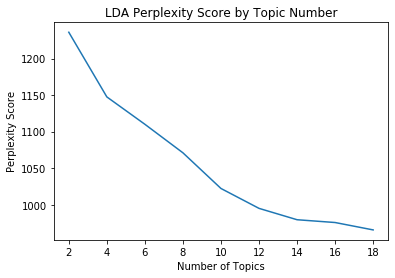

In [164]:
# Plot the perplexity scores
plt.plot(range(2, 19, 2), p);
plt.title('LDA Perplexity Score by Topic Number');
plt.ylabel('Perplexity Score');
plt.xlabel('Number of Topics');

The sharpest decline in perplexity score happens from two to four topics, with steady declines until 10-12 topics. After that point, the scores still drop but at an almost neglible rate.

## NMF

In [181]:
# Create and fit an NMF model with just CountVectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [182]:
show_topics(H1, vocab)

['water clean act protections protect drinking river life',
 'waters states united definition federal act navigable ephemeral',
 'streams wetlands downstream rule proposed flow small rivers',
 'waterways water act proposal streams families waters drinking',
 'rule proposed epa wotus case 2015 support environmental',
 'water farmers rules land rule epa clear new',
 'waterways rule proposed streams wetlands new categories protections',
 'water protections park streams quality wetlands clean parks',
 'waters united states dirty rule dangerous people water',
 'water clean communities rule epa polluters waterways dirty',
 'water definition wotus proposed drinking cwa bodies rule',
 'wetlands streams protection wetland epa wildlife species ecosystems']

In [183]:
# Create and fit an NMF model with CountVectorizer and TF-IDF
nmf = NMF(n_components=n_topics,
          random_state=42)

W1_tf = nmf.fit_transform(tfv_data)
H1_tf = nmf.components_

In [184]:
show_topics(H1_tf, vocab)

['definition wotus waters rule states united 2015 proposed',
 'water waterways families act proposal clean streams love',
 'water communities clean dirty polluters instead rule families',
 'rules farmers land clear water support new landowners',
 'concerned harmed protections overall remove loss rappahannock impact',
 'dangerous dirty united waters states agencys water jeopardize',
 'blanket handout arroyos acequias disregards connectivity cinegas imperative',
 'park parks water protections wetlands quality streams small',
 'downstream streams wetlands flow small rule allowing water',
 'waterways categories proposed unprotected recreate mexico arizona nevada',
 'water clean life act protect need people regulations',
 'niagara usepa percent wetlands streams buffalo waters including']